In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import warnings
warnings.filterwarnings("ignore")

In [72]:
df = pd.read_excel('../database/export_binance/df_new.xlsx', index_col=0)
df.head(3)

,User_ID,UTC_Time,Account,Operation,Coin,Change,Remark
1,1,2021-05-31 09:00:00,Spot,Deposit,SOL,25.0,NaN
1,1,2021-05-31 09:00:00,Spot,Deposit,BTC,1.0,NaN
1,1,2021-05-31 09:00:00,Spot,Deposit,BNB,35.0,NaN


In [74]:
df_card = df.loc[df['Account'] == 'Card']
df_card.head(3)

,User_ID,UTC_Time,Account,Operation,Coin,Change,Remark
823,11233391,2021-06-05 22:24:30,Card,Binance Card Spending,EUR,-33.000000,NaN
824,11233391,2021-06-07 06:24:37,Card,Card Cashback,BNB,0.000823,NaN
952,11233391,2021-06-08 05:10:12,Card,Card Cashback,BNB,0.003474,NaN


In [82]:
card_balance = pd.DataFrame(df_card.groupby('Coin').sum()['Change'])
card_balance.head(3)

,Change
Coin,
BNB,0.119919
EUR,7.270000


In [83]:
df_current_prices = pd.read_excel('../database/prices/current_prices.xlsx', index_col=0)
holding_prices = []
for i in card_balance.index:
    if i == 'USDT':
        holding_prices.append(1)
    else:
        try:
            price = df_current_prices.loc[df_current_prices['symbol'] == (i + 'USDT')]['price'].values[0]
            holding_prices.append(price)
        except:
            holding_prices.append(np.nan)
card_balance = pd.DataFrame(card_balance)
card_balance['USDT_price'] = holding_prices
card_balance['USDT_value'] = holding_prices * card_balance['Change']
print(f'current total value: {round(card_balance["USDT_value"].sum(), 2)} USDT')
card_balance.sort_values(by='USDT_value', ascending=False, inplace=True)
card_balance = card_balance.loc[card_balance['USDT_value'] > 1]
card_balance

current total value: 42.32 USDT


,Change,USDT_price,USDT_value
Coin,,,
BNB,0.119919,287.900,34.524815
EUR,7.270000,1.072,7.793440


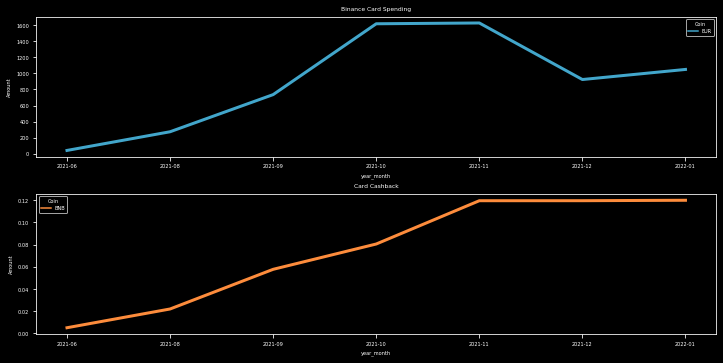

In [108]:
expenses = df_card.loc[df_card['Operation'] == 'Binance Card Spending']
expenses['year_month'] = expenses['UTC_Time'].dt.strftime('%Y-%m')
expenses = expenses.pivot_table(index='year_month', columns='Coin', values='Change', aggfunc=np.sum)

rewards = df_card.loc[df_card['Operation'] == 'Card Cashback']
rewards['year_month'] = rewards['UTC_Time'].dt.strftime('%Y-%m')
rewards = rewards.pivot_table(index='year_month', columns='Coin', values='Change', aggfunc=np.sum)

fig, ax = plt.subplots(2, 1, figsize = (10,5))
ax = ax.flat
plt.rcParams['font.size'] = '5'
sns.lineplot(data=expenses.cumsum()*-1, ax = ax[0], legend=True, palette='GnBu_d', linewidth=3)
#sns.lineplot(data=funding.cumsum(), ax = ax[0], legend=True, palette='RdYlBu_d', linewidth=3)
ax[0].set_title('Binance Card Spending')
ax[0].set_ylabel('Amount')
#ax[0].grid(True)
sns.lineplot(data=rewards.cumsum(), ax = ax[1], legend=True, palette='YlOrRd', linewidth=3)
ax[1].set_title('Card Cashback')
ax[1].set_ylabel('Amount')
#ax[1].grid(True)
plt.tight_layout()
plt.show();

In [109]:
funding = pd.DataFrame(df_card.loc[(df_card['Operation'] == 'transfer_in') | (df_card['Operation'] == 'transfer_out')])
funding['year_month'] = funding['UTC_Time'].dt.strftime('%Y-%m')
funding = funding.groupby(['Coin', 'year_month']).sum()['Change'].reset_index()
funding

,Coin,year_month,Change
0,EUR,2021-08,638.77
1,EUR,2021-09,1000.00
2,EUR,2022-01,-581.35


## expenses projection model